In [23]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

In [24]:
# Configurar conexão com MySQL
usuario = "root"
senha = "admin"
host = "0.0.0.0"  # Exemplo: "localhost"
banco = "projecoes2_banco"

# Criando a conexão com o banco de dados
engine = create_engine(f"mysql+mysqlconnector://{usuario}:{senha}@{host}/{banco}")

# Caminho relativo ao arquivo SQL dentro da pasta DBT
sql_file_path = "project2_dbt/models"
sql_files = {
    "projecoes": sql_file_path + "/vw_projecao.sql",
    "etario": sql_file_path + "/vw_etario.sql",
    "socio": sql_file_path + "/vw_socio.sql",
    "salario": sql_file_path + "/vw_salario.sql"
}

# Função para ler e executar uma query SQL e retornar o dataframe resultante
def executar_query(sql_file):
    with open(sql_file, "r", encoding="utf-8") as file:
        query = file.read()
    return pd.read_sql(query, engine)

# Automatizando a execução das consultas
projecoes2_df_filtrado = executar_query(sql_files["projecoes"])
etario_filtrado = executar_query(sql_files["etario"])
socio_filtrado = executar_query(sql_files["socio"])
idade_inst_sal = executar_query(sql_files["salario"])

# Fechar a conexão
engine.dispose()

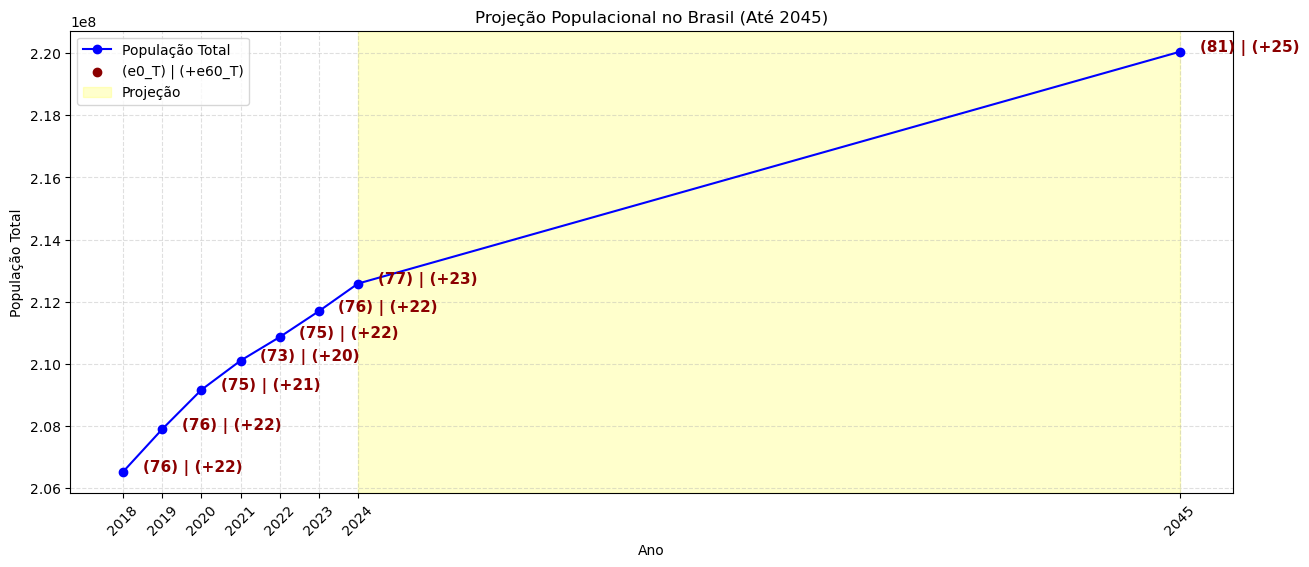

In [25]:
# Criar o gráfico principal
plt.figure(figsize=(15, 6))

plt.plot(projecoes2_df_filtrado["year"], projecoes2_df_filtrado["pop_t"],
         marker="o", linestyle="-", color="b", label="População Total")

# Adicionar valores nos pontos do gráfico
for ano, pop, e0_T, e60_T in zip(projecoes2_df_filtrado["year"], 
                                 projecoes2_df_filtrado["pop_t"],
                                 projecoes2_df_filtrado["e0_t"], 
                                 projecoes2_df_filtrado["e60_t"]):

    plt.text(ano + 0.5, pop, f"({e0_T:,.0f}) | (+{e60_T:,.0f})", 
             ha="left", fontsize=11, color="darkred", fontweight="bold")

# Criar um marcador invisível para incluir na legenda
plt.scatter([], [], color="darkred", label="(e0_T) | (+e60_T)")

# Destacar uma região com transparência (exemplo: entre os anos 2024 e 2045)
plt.axvspan(2024, 2045, color="yellow", alpha=0.2, label="Projeção")

# Personalização
plt.xlabel("Ano")
plt.ylabel("População Total")
plt.title("Projeção Populacional no Brasil (Até 2045)")
plt.xticks(projecoes2_df_filtrado["year"], rotation=45)  # Rotacionar anos no eixo x
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

# Mostrar o gráfico
plt.show()


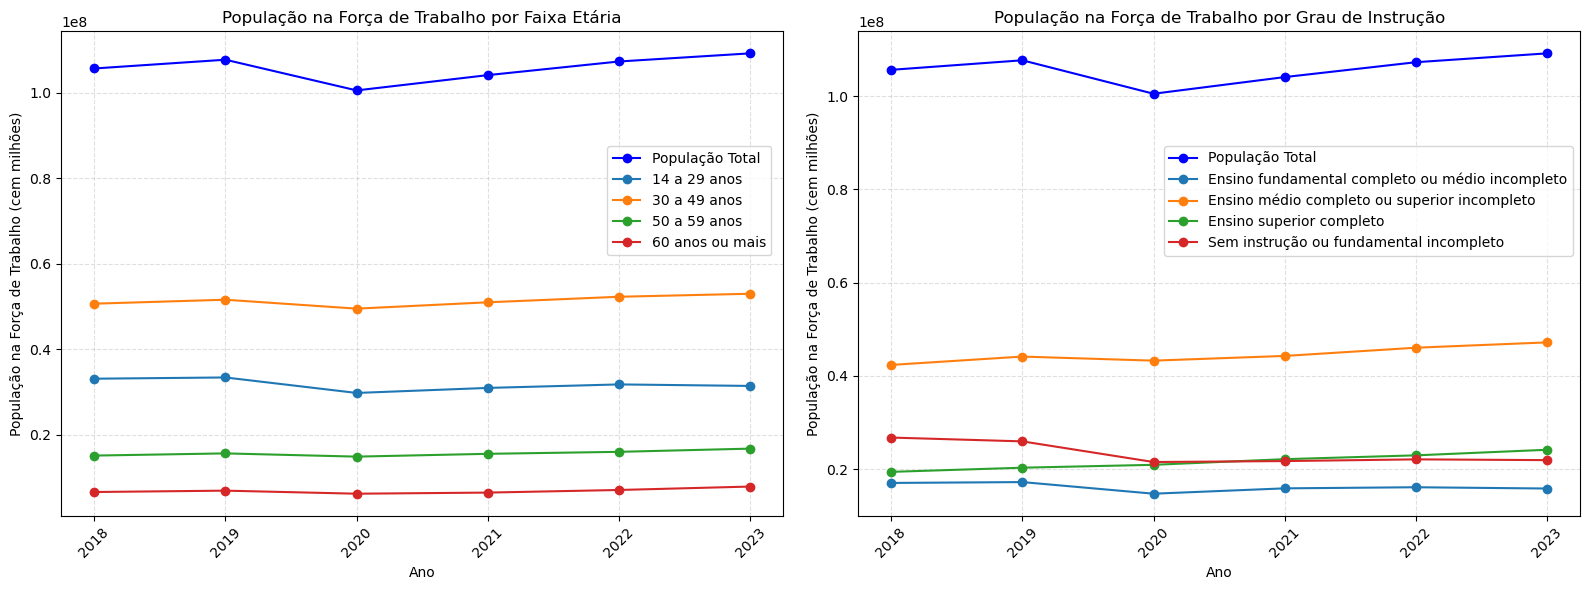

In [26]:
# Criar o gráfico com 1 linha e 2 colunas
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: População por faixa etária ao longo dos anos
axs[0].plot(etario_filtrado["year"].unique(), 
            etario_filtrado.groupby("year")["total_work_pop_etario"].sum(), 
            marker="o", linestyle="-", color="b", label="População Total")

# Definindo as faixas etárias
faixas_etarias = [
    "14 a 29 anos", 
    "30 a 49 anos", 
    "50 a 59 anos", 
    "60 anos ou mais"
]

# Iterando sobre as faixas etárias e gerando o gráfico para cada uma
for faixa in faixas_etarias:
    faixa_data = etario_filtrado[etario_filtrado["features"] == faixa]
    axs[0].plot(faixa_data["year"].unique(), 
                faixa_data.groupby("year")["total_work_pop_etario"].sum(), 
                marker="o", linestyle="-", label=faixa)

# Adicionar rótulos e título para o gráfico 1
axs[0].set_xlabel("Ano")
axs[0].set_ylabel("População na Força de Trabalho (cem milhões)")
axs[0].set_title("População na Força de Trabalho por Faixa Etária")
axs[0].tick_params(axis="x", rotation=45)
axs[0].grid(True, linestyle="--", alpha=0.4)
axs[0].legend(loc="center", bbox_to_anchor=(0.87, 0.65))

# Gráfico 2: População por grau de instrução ao longo dos anos
axs[1].plot(socio_filtrado["year"].unique(),
            socio_filtrado.groupby("year")["total_work_pop_etario"].sum(),
            marker="o", linestyle="-", color="b", label="População Total")

# Agrupar os dados por ano e grau de instrução, somando a população de homens e mulheres
total_por_grau = socio_filtrado.groupby(['year', 'degree'])['total_work_pop_etario'].sum().reset_index()

# Plotando a soma da população para cada grau de instrução ao longo dos anos
for grau in total_por_grau['degree'].unique():
    grau_data = total_por_grau[total_por_grau['degree'] == grau]
    axs[1].plot(grau_data["year"], grau_data["total_work_pop_etario"], marker="o", linestyle="-", label=grau)

# Adicionar rótulos e título para o gráfico 2
axs[1].set_xlabel("Ano")
axs[1].set_ylabel("População na Força de Trabalho (cem milhões)")
axs[1].set_title("População na Força de Trabalho por Grau de Instrução")
axs[1].tick_params(axis="x", rotation=45)
axs[1].grid(True, linestyle="--", alpha=0.4)
axs[1].legend(loc="center right", bbox_to_anchor=(1, 0.65))

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar os gráficos
plt.show()

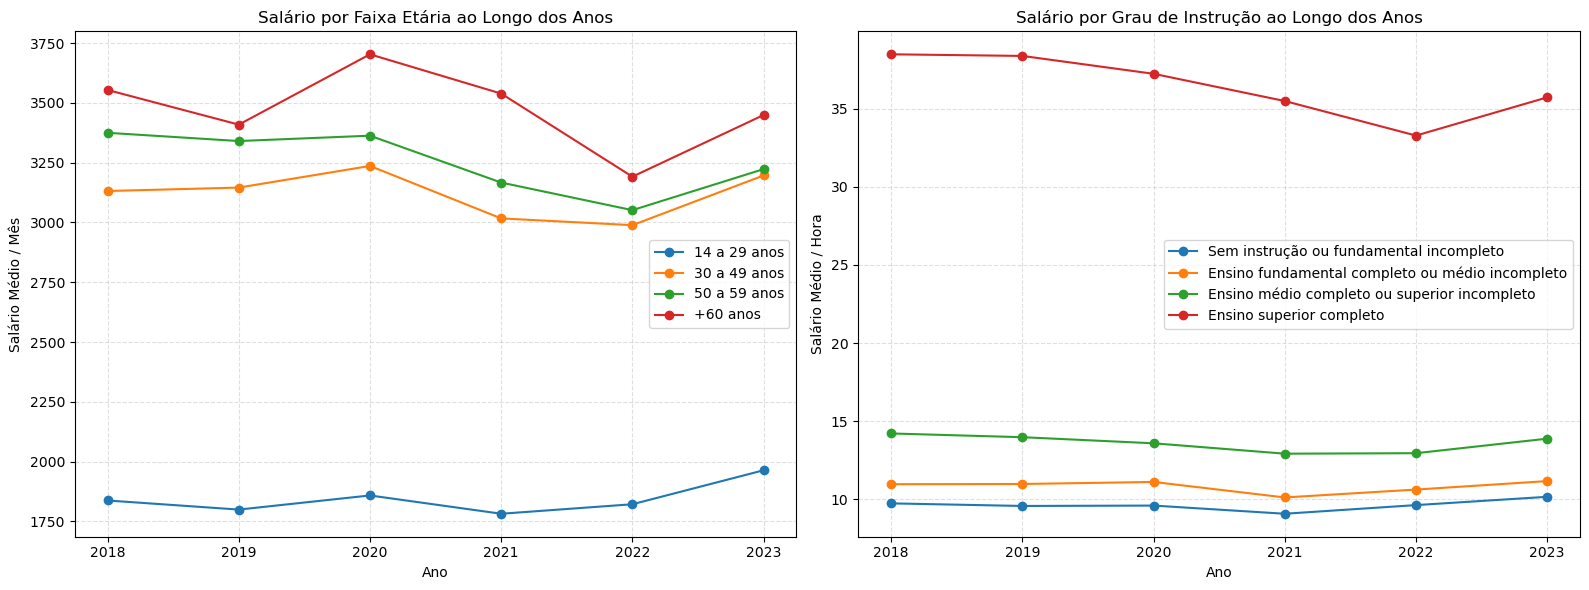

In [29]:
# Criar a figura com 2 gráficos lado a lado
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Salário (X) vs Ano (Y) - Grau de Instrução

colunas_desejadas_IDADE = {
    "14 a 29 anos": "age_14_29",
    "30 a 49 anos": "age_30_49",
    "50 a 59 anos": "age_50_59",
    "+60 anos": "age_60_plus"
}

for legenda_idade, col in colunas_desejadas_IDADE.items():
    axs[0].plot(idade_inst_sal["year"], idade_inst_sal[col], marker="o", linestyle="-", label=legenda_idade)

axs[0].set_xlabel("Ano")
axs[0].set_ylabel("Salário Médio / Mês")
axs[0].set_title("Salário por Faixa Etária ao Longo dos Anos")
axs[0].grid(True, linestyle="--", alpha=0.4)
axs[0].legend(loc="best")

colunas_desejadas_INST = {
    "Sem instrução ou fundamental incompleto": "incomplete",
    "Ensino fundamental completo ou médio incompleto": "elementary",
    "Ensino médio completo ou superior incompleto": "high",
    "Ensino superior completo": "college"
}

# Gráfico 2: Salário (X) vs Ano (Y) - Faixa Etária
for legenda, coluna in colunas_desejadas_INST.items():
    axs[1].plot(idade_inst_sal["year"], idade_inst_sal[coluna], marker="o", linestyle="-", label=legenda)

axs[1].set_xlabel("Ano")
axs[1].set_ylabel("Salário Médio / Hora")
axs[1].set_title("Salário por Grau de Instrução ao Longo dos Anos")
axs[1].grid(True, linestyle="--", alpha=0.4)
axs[1].legend(loc="best")
    
plt.tight_layout()
plt.show()
